# Chapter3.평가

### 분류의 성능 평가 지표
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC/AUC

## 01.정확도(Accuracy)
### : 정확도 = 잘 예측한 데이터 수 / 전체 데이터 수
#### - 가장 직관적인 평가 지표
#### - 불균형한 데이터에서의 분류 모델을 평가할 경우 적합한 지표가 아님
Ex) 1이 90개, 0이 10개일 때 모두 1로 분류하는 분류 모델의 정확도는 90%

### 정확도(Accuracy)가 평가지표로서 부적절한 경우
### 사례 1 - 타이타닉 생존 분류 모델

In [6]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    
    # 데이터에서 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    
    # sex가 1이면 0, 그렇지 않으면 1로 예측하는 모델
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] ==1:
                pred[i] = 0
            else :
                pred[i] = 1
        return pred

In [28]:
### 데이터 전처리 함수 생성

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성(열) 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행 : 분류의 범주값을 숫자로 변환(Ex.TV:0, 냉장고:1, 믹서:2, ...)
from sklearn.preprocessing import LabelEncoder

def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 한번에 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터 로딩, 데이터 가공
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1) # 데이터에서 Survived 열을 제거, axis = 1 : 열 방향으로 drop
X_titanic_df = transform_features(X_titanic_df)

# train_test_split : 트레인 데이터, 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypred = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test,mypred)))

Dummy Classifier의 정확도는: 0.7877


단순하게 여자는 1, 남자는 0으로 예측한 모들의 정확도가 78%로 높게 나온다.

### 사례 2 - MNIST 데이터 세트
MNIST : 0부터 9까지의 숫자 이미지 픽셀 정보를 가지는 데이터셋,
7인 것을 찾아내고 싶을 때, 모두 False로 예측하는 분류모델을 만든다.

In [16]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    
    # 아무 것도 학습하지 않음
    def fit(self, X, y):
        pass
    
    # 모두 0으로 예측
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
    
# 사이킷런의 내장 데이터셋 MNIST 로딩
digits = load_digits()

# 평가에 사용할 정답 데이터셋 만들기
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state = 11)

In [20]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


#### 사례 1, 2처럼 불균형한 데이터의 경우 정확도만으로 평가하기엔 부족하다!
#### => 여러 가지 분류 지표와 함께 평가!!

## 02.오차행렬(Confusion Matrix, 혼돈행렬)
### : 이진 분류의 예측 오류 + 예측 오류의 유형을 함께 나타내는 지표
- TN(True Negative) : 0으로 예측, 실제 0
- FP(False Positive) : 1로 예측, 사실 0
- FN(False Negative) : 0으로 예측, 사실 1
- TP(True Positive) : 1로 예측, 실제 1

In [21]:
from sklearn.metrics import confusion_matrix

# confusion_matrix(실제값, 예측값) : 혼돈행렬을 만들어준다.
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

TN(array[0,0]) : 405 => 405개는 실제 False이면서 False로 맞게 예측함

FN(array[1,0]) : 45 => 45개는 True였으나, False로 잘못 예측함

## 03.정밀도(Precision)와 재현율(Recall)
### : Positive 데이터의 예측 성능에 초점을 맞춘 평가지표(실제 1을 얼마나 잘 예측했는지)
- 정밀도 = TP / (FP+TP) : 1로 예측한 것 중에 실제 1의 비율
- 재현율 = TP/ (FN+TP) : 실제 1중에 1로 예측한 것의 비율. 민감도(Sensitivity), TPR(True Positive Rate)라고도 불림

### 정밀도
- TP / (FP + TP)
- (실제 Positive & 예측 Positive) / (예측 Positive)
- FP를 줄이는 것이 목적(실제 Negative를 Positive로 예측하는 오류)
- FP 오류가 치명적일 때 중요한 지표
Ex. 실제 스팸이 아닌 메일(Negative)을 스팸메일(Positive)로 분류할 때

### 재현율=민감도=TPR
- TP / (FN + TP)
- (실제 Positive & 예측 Positive) / (실제 Positive)
- FN을 줄이는 것이 목적(실제 Positive를 Negative로 예측하는 오류)
- FN 오류가 치명적일 때 중요한 지표
Ex1.실제 양성인 암 환자(Positive)를 음성(Negative)으로 판단할 때
Ex2. 실제 금융거래 사기(Positive)를 정상 금융거래(Negative)로 판단할 때


In [34]:
# 온갖 평가 지표를 한꺼번에 호출하는 함수 생성
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터 로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv') # 데이터 로딩

y_titanic_df = titanic_df['Survived'] 
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df) # 데이터 가공

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=11) # 트레인, 테스트 데이터 분할

# 트레인 데이터에 로지스틱 회귀 모델 적합 및 예측
lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

# 평가
get_clf_eval(y_test, pred)



오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도:0.8246, 재현율:0.7705


C:\Users\parka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


- 정밀도에 비해 재현율이 낮게 나왔다.
- => FN가 많다=1을 0으로 잘못 예측한 경우가 많다.
- => 재현율을 높이려면 어떻게 해야 하는가?

### * 정밀도/재현율 트레이드 오프
: 정밀도, 재현율의 어느 한 쪽을 높이면 다른 하나의 수치는 떨어진다.

In [37]:
### predict_proba() 메서드 : 분류 모델에서 데이터 별로 각 클래스를 가질 예측 확률을 구한다. 반환 결과가 예측 확률 결과

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape:{0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측확률 array와 예측결괏값 array 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)],axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])

pred_proba()결과 Shape:(179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935228 0.55064772]
 [0.86335513 0.13664487]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935228 0.55064772 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]]


- 각 행에서 예측 확률 값의 합은 1이며, 예측 확률이 큰 클래스로 predict()메서드가 최종 예측한다.
- 다시 말해, Positive로 예측하는 기준은 예측 확률이 0.5보다 클 때 이며, 이 임계값을 조정하여 정밀도/재현율을 트레이드오프 시킬 수 있다.

#### Binarizer 클래스를 이용해 임계값 변경하기

In [40]:
# Binarizer(threshold) : threshold값을 기준으로 0/1을 반환한다.
from sklearn.preprocessing import Binarizer

X = [[ 1, -1, 2],
     [ 2, 0, 0],
     [ 0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환한다.
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [41]:
from sklearn.preprocessing import Binarizer

# Binarizer의 임계값 설정
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼(=Positive 칼럼) 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도:0.8246, 재현율:0.7705


#### 임계값 0.4로 변경

In [42]:
custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도:0.7042, 재현율:0.8197


- 임계값을 낮추니(더 많은 값을 Positive로 예측 => TP 증가)
- FN 감소 => 재현율(TP/(FN+TP)) 증가
- FP 증가 => 정밀도(TP/(FP+TP)) 감소

#### 임계값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사

In [43]:
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_thresholds(y_test, pred_proba_c1, thresholds):
    
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_thresholds(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임계값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도:0.7042, 재현율:0.8197
임계값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도:0.7869, 재현율:0.7869
임계값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도:0.8246, 재현율:0.7705
임계값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도:0.8654, 재현율:0.7377
임계값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도:0.8980, 재현율:0.7213


#### 임계값 변화에 따른 평가지표 값 보기 - precision_recall_curve()

In [44]:
from sklearn.metrics import precision_recall_curve

# class 1로 예측할 예측확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제 데이터 셋과 class 1로 예측할 예측확률을 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건을 추출하되, 임계값을 15 Step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임계값 배열의 Shape: (147,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값: [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도: [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


임계값이 증가할수록 정밀도는 증가하고, 재현율은 낮아진다.

#### 임계값에 따른 재현율과 정밀도 곡선 시각화

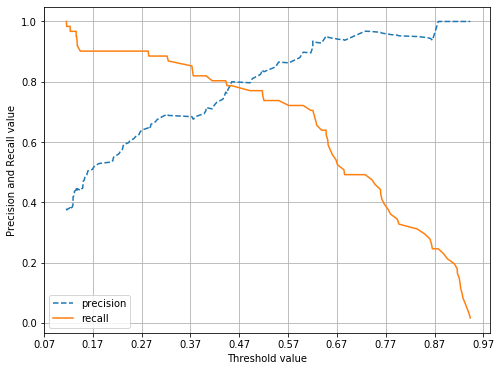

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    
    # threshold ndarray와 이 임계값에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle="--", label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

임계값이 낮을수록 많은 값을 양성예측하므로 재현율이 증가, 정밀도가 낮아진다.
이 곡선에서 임계값이 약 0.45일 때 재현율과 정밀도가 비슷해진다. => 바람직한 임계값

#### 정밀도와 재현율의 맹점
- 모두 Negative 예측 => 정밀도 100%
- 모두 Positive 예측 => 재현율 100%
- => 정밀도, 재현율을 모두 고려하는 평가 지표 필요

## 04.F1 스코어
### : 정밀도와 재현율의 조화 평균
### F1 = 2/{(1/recall)+(1/precision)}
- 극단적으로 낮은 값의 영향을 많이 받는다
- => 정밀도와 재현율의 값이 비슷할 때 F1 값이 크다.

In [48]:
# f1_score() : F1 스코어를 구하는 API

from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7966


In [53]:
# 타이타닉 생존자 예측에서 임계값을 변화시키면서 F1 포함 평가지표 구하기

def get_clf_eval(y_test , pred):
    
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    
    print('오차 행렬')
    print(confusion)
    
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_thresholds(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576
임계값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869
임계값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966
임계값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965
임계값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000


임계값이 0.6일 때 F1 스코어가 가장 높으나, 재현율이 낮음.

### 05.ROC 곡선과 AUC
#### ROC 곡선 : FPR(False Positive Rate)이 변할 때  TPR(True Positive Rate)의 변화를 나타내는 곡선
- 민감도(TPR) : TP / (FN + TP)
- 특이성(TNR) : TN / (FP + TN) => FPR = 1 - 특이성

#### 임계값 변화시키며 FPR, TPR 구하기 : roc_curve() API

In [55]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 0  5 10 15 20 25 30 35 40 45]
샘플용 10개의 임곗값:  [1.94 0.87 0.63 0.55 0.44 0.32 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.059 0.127 0.203 0.559 0.602 0.695 0.847]
샘플 임곗값별 TPR:  [0.    0.246 0.672 0.738 0.787 0.885 0.902 0.951 0.967 0.984]


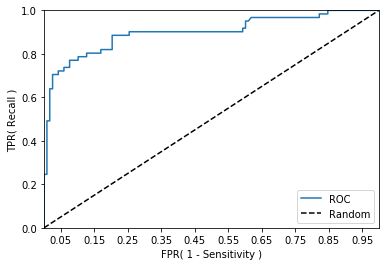

In [59]:
def roc_curve_plot(y_test , pred_proba_c1):
    
    # 임곗값에 따른 FPR, TPR 값을 반환 받음
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, x, y축 설정 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

ROC의 베이스라인은 Random 수준(동전 던지기 수준)이며, ROC의 면적(AUC)가 커질수록 좋은 수치이다.

#### AUC 구하기 : roc_auc_score() API

In [60]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8429


AUC의 베이스라인은 0.5(동전 던지기 수준)이다.

## 06.피마 인디언 당뇨병 예측

In [61]:
# 데이터 불러오기 및 데이터 확인

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- Pregnancies : 임신 횟수
- Glucose : 포도당 부하 검사 수치
- BloodPressure : 혈압
- SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값
- Insulin : 혈청 인슐린
- BMI : 체질량지수
- Dia~ : 당뇨 내력 가중치값
- Age : 나이
- Outcome : 클래스 결정 값 (0/1)

실제 0 :500개, 1:268개

In [66]:
# 피처 데이터 세트 X, 레이블(클래스) 데이터셋 y를 추출 
# 맨 끝이 Outcome으로 레이블 칼럼임
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1:0.6465


C:\Users\parka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


정확도는 77%로 높으나, 전체 데이터에서 대부분이 Negative인 불균형한 데이터 셋이므로 정확도보다는 재현율/정밀도에 초점

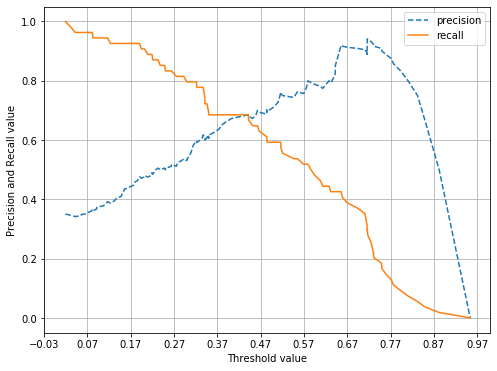

In [67]:
# ROC 곡선 시각화
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임계값이 0.42정도일 때 재현율과 정밀도가 비슷해지지만, 0.7도 안되는 낮은 값을 가진다. 데이터 값을 점검해보자!

In [68]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min 값이 0인 경우가 많다. 그러나 Glucose는 포도당 수치인데 0일리가 없다. => 결측치가 0으로 들어간 것 같다!

In [70]:
### 각 칼럼에서 0의 비율을 확인해보자

# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count,
                                                 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


SkinThickness와 Insulin은 0의 비율이 많으므로 제거하면 학습이 힘들어진다. 따라서 mean으로 대체

In [71]:
# 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [73]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2,
                                                    random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test , pred)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804


C:\Users\parka\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


성능 수치가 다소 개선되었으나 아직 재현율 수치는 개선이 필요 => 임계값을 조정

In [75]:
# 0.3에서 0.5까지 0.03씩 변화시키면서 재현율, 정밀도 확인

thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_thresholds(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임계값: 0.3
오차 행렬
[[65 35]
 [11 43]]
정확도: 0.7013, 정밀도: 0.5513, 재현율: 0.7963, F1:0.6515
임계값: 0.33
오차 행렬
[[71 29]
 [11 43]]
정확도: 0.7403, 정밀도: 0.5972, 재현율: 0.7963, F1:0.6825
임계값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1:0.6667
임계값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1:0.6667
임계값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1:0.6792
임계값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857
임계값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931
임계값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804


임계값이 0.48일 때 F1, AUC가 가장 높으므로 0.48을 선택